In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

batch_size = 128
num_epochs = 100
seed = 1
out_dir = './mnist_vae'

In [2]:
cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

cuda is available!


In [3]:
# (image, label) = [(batch,channel,h,w), (batch)] 
# channel=1, h=28, w=28
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=True,
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=False,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

In [4]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(784, 512)
        self.fc21 = nn.Linear(512, 100)  # mu
        self.fc22 = nn.Linear(512, 100)  # logvar

        self.fc3 = nn.Linear(100, 512)
        self.fc4 = nn.Linear(512, 784)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h))
    
    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE()
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
def loss_function(recon_x, x, mu, logvar):
    # size_average=Falseなのでバッチ内のサンプルの合計lossを求める
    # reconstruction loss 入力画像をどのくらい正確に復元できたか？
    # 数式では対数尤度の最大化だが交差エントロピーlossの最小化と等価
    recon = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)

    # 潜在空間zに対する正則化項
    # P(z|x) が N(0, I)に近くなる（KL-distanceが小さくなる）ようにする
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon + kld

In [6]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if cuda:
            data = Variable(data.cuda())
        else:
            data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
    
    # loss_function() は平均ではなく全サンプルの合計lossを返すのでサンプル数で割る
    train_loss /= len(train_loader.dataset)

    return train_loss    
    

def test(epoch):
    model.eval()
    test_loss = 0
    for batch_idx, (data, _) in enumerate(test_loader):
        if cuda:
            data = Variable(data.cuda(), volatile=True)
        else:
            data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        test_loss += loss.data
        
        if epoch % 10 == 0:
            # 10エポックごとに最初のminibatchの入力画像と復元画像を保存
            if batch_idx == 0:
                n = 8
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.data.cpu(),
                           '{}/reconstruction_{}.png'.format(out_dir, epoch), nrow=n)

    test_loss /= len(test_loader.dataset)

    return test_loss

loss_list = []
test_loss_list = []
for epoch in range(1, num_epochs + 1):
    loss = train(epoch)
    test_loss = test(epoch)

    print('epoch [{}/{}], loss: {:.4f} test_loss: {:.4f}'.format(
        epoch,
        num_epochs,
        loss,
        test_loss))

    # logging
    loss_list.append(loss)
    test_loss_list.append(test_loss)

# save the training model
np.save(out_dir+'/loss_list.npy', np.array(loss_list))
np.save(out_dir+'/test_loss_list.npy', np.array(test_loss_list))
torch.save(model.state_dict(), out_dir+'/vae.pth')

/home/pip/junya_yasuda/.conda/envs/py36-yasuda/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/pip/junya_yasuda/.conda/envs/py36-yasuda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


epoch [1/100], loss: 168.3235 test_loss: 125.0661
epoch [2/100], loss: 129.6924 test_loss: 109.8340
epoch [3/100], loss: 118.3517 test_loss: 104.0255
epoch [4/100], loss: 113.1375 test_loss: 100.8750
epoch [5/100], loss: 110.4462 test_loss: 99.0752
epoch [6/100], loss: 108.7814 test_loss: 97.5696
epoch [7/100], loss: 107.6425 test_loss: 97.2491
epoch [8/100], loss: 106.8675 test_loss: 96.4611
epoch [9/100], loss: 106.2858 test_loss: 96.2687
epoch [10/100], loss: 105.7521 test_loss: 95.0117
epoch [11/100], loss: 105.3366 test_loss: 94.8452
epoch [12/100], loss: 105.0821 test_loss: 94.6751
epoch [13/100], loss: 104.7995 test_loss: 94.2751
epoch [14/100], loss: 104.5734 test_loss: 94.6534
epoch [15/100], loss: 104.4007 test_loss: 94.3290
epoch [16/100], loss: 104.1852 test_loss: 94.1006
epoch [17/100], loss: 104.0168 test_loss: 94.3407
epoch [18/100], loss: 103.8613 test_loss: 94.6968
epoch [19/100], loss: 103.6885 test_loss: 94.2043
epoch [20/100], loss: 103.5640 test_loss: 93.5805
epoch

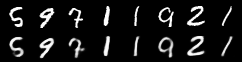

In [9]:
from IPython.display import Image
Image(out_dir+'/reconstruction_10.png')

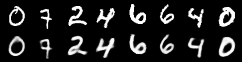

In [10]:
Image(out_dir+'/reconstruction_100.png')

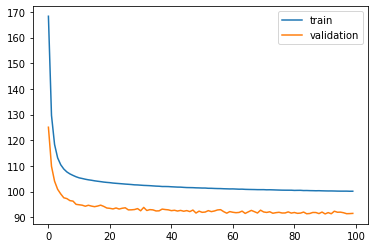

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
x = [i for i in range(len(loss_list))]
plt.plot(x, loss_list, label="train")
plt.plot(x, test_loss_list, label="validation")
plt.legend()
plt.show()